This code is inspired in Chapter 8 of the [Computational Physics](https://farside.ph.utexas.edu/teaching/329/329.pdf) book by Richard Fitzpatrick, Professor of Physics at The University of Texas at Austin.

Have a look at the [Computational Plasma Physics: Powerful New Tools of Scientific Discovery](https://w3.pppl.gov/~hammett/refs/2012/NUF_12_computational.pdf) lecture, given by Princeton Plasma Physics Lab (PPPL).

In [1]:
## REMEMBER TO ACTIVATE `GPU_optimization (aGPUo)`

#import tensorflow
import torch
import os
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scienceplots

from matplotlib import animation
from matplotlib.animation import PillowWriter

plt.style.use(['science', 'notebook'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

## [TWO STREAM INSTABILITY](https://farside.ph.utexas.edu/talks/pic.pdf)

Consider N fixed ions and N moving electrons as an one-dimensional unmagnetized plasma (B=0) -- quick remark: plasmas are usually much less dense than liquids (such as water). The equations of motion for this system are

$$
    d_t r_i = v_i;\quad d_t v_i = -\frac{e}{m_e}E(r_i)
$$

For the numerical solution of this system, it is important to notice that it is not necessary to discretize positions nor velocities; the discretization
in space is only for the solution of the Poisson equation. **Therefore there is no truncation error regarding the positions and velocities of the electrons; it is only rounding error.**

Posson equation states that

$$
    d^2_x \Phi(x) = -\frac{e}{m_e}(n_o-n(x)); \quad d_x\Phi(x) = - E(x),
$$

with $n_o = N/L = <n(x)>$ being the uniform ion number density; and, $n(x)$ is the electron number density. Now, consider two counter-propagating Maxwellian beams of mean speed $v_b$ and thermal velocity $v_{th}$; thus, 

$$
    f(x,v) = \frac{n_o}{2\sqrt{2\pi}v{th}}\left[exp\left(-\frac{1}{2v^2_{th}}\left(v - v_b\right)^2\right) + exp\left(-\frac{1}{2v^2_{th}}\left(v + v_b\right)^2\right)\right].
$$

With this, one can obtain $f(x,v)dxdv$ the number of electrons in between $x$ + $x+dx$ with velocities $v$ and $v + dv$. Also, one can obtain the electron number density by integrating over the entire velocity space. The definition of the thermal velocity is

$$
    v_{th} = \sqrt{\frac{k_bT}{m_e}}
$$

Where $k_b$ is the Boltzmann constant. It is important to know that if $v_b >> v_{th}$ , then, the Maxwellian distribution becomes unstable to the well-known two-stream instability . It is possible to investigate this instability numerically.

### PERIODIC BOUNDARY CONDITIONS

By considering periodic boundary contions, one can easily see that for $0\leq x \leq L$:

* $n(0) = n(L)$
* $E(0) = E(L)$
* $\Phi(0) = \Phi(L)$
* Electrons that crosses the right boundary should reappear in the left boundary and vice versa.

To reduce rounding error, one can consider the normalized variables: normalize time with respect the plasma frequency $\omega_p$ and the Debye length $\lambda_D$
for spatial quantities:

$$
    \omega^2_p = \frac{n_oe^2}{\epsilon_o m_e}; \quad \lambda_D = \frac{v_{th}}{\omega_p}
$$

Thus, the set of equations that describe the system become:

* $d_t r_i = v_i$
* $d_t v_i = -E(r_i)$
* $d_x\Phi(x) = -E(x)$
* $d^2_x\Phi(x) = n(x)/n_o - 1$
* $v_{th}$ = 1

And the distribution function takes the form of 

$$
    f(x,v) = \frac{n_o}{2\sqrt{2\pi}}\left[ exp\left(-\frac{1}{2}\left(v-v_b\right)^2\right) + exp\left(-\frac{1}{2}\left(v+v_b\right)^2\right) \right]
$$

# MODEL

### EQUATIONS OF MOTION $\rightarrow$ Runge-Kutta Methods

For the equations of motions, we will be considering the 4-th order Runge Kutta (RK4).

Runge-Kutta methods solve initial value problems (IVP). In the context of multivariate calculus, IVP are is ordinary differential equations with initial conditions which specify the value of the unknown functions at a given point in the domain ([recommended to check the existence and uniqueness of solutions](https://www.math.iitb.ac.in/~siva/ma41707/ode3.pdf)). The different types of Runge-Kutta methods, can be observed in the following image. 

![alt text](Images/Runge-Kutta.png "Gebraeuchliche Varienten des Runge-Kutta-Verfahrens")

_Figure from the **C.-D. M. Westermann, Numerische Behandlung gewöhnlicher und partieller Differenzialgleichungen. Springer,
2019.** book_.

### PARTICLE DENSITY $n(x) \rightarrow$ Particle in Cell Method

To be able to solve the equations of motions, it is necesary to know the electric field $E(x)$ and the electric potential $\Phi(x)$. **Remark: Potentials are Boundary Value Problems (BVP)**. Thus, it is convenient to consider the Particle in Cell Method for the calculation of $n(x)$.  

To implement the PIC method, let us follow:

1. Discretize the space: $ 0 \leq x \leq L $.

    $$
        x_j = j\cdot \delta x;\quad \text{with}\quad \delta x = \frac{L}{J}, \quad \text{and} \quad j \in [0,J],
    $$

with $\{r_i, v_i\}; i \in [0,N-1]$. Each discretization will be referred as `the cell`. Of course, $N >> J$, such that there is a lot more than one particle per cell. For simplicity of notation: 

$$
    n_j = n(x_j);\quad and\quad \Phi_j = \Phi(x_j)
$$

There is one fundamental assumption that will direclty impact how $n_j$ is computed, and it is that **each particle has an homogeneous distribution of size $\delta x$ as charge clound**. As a consequence, one must be cautios how the addition is going to be added per cell. The discretization of space and the consideration per cell is designed as follows:


<img src="Images/pic_method_nj_xj.jpg" width="800" height="400">

From the fact that the cloud charge is of size $\delta x$, then, it is thus assumed that $x_j \leq r_i \leq x_{j+1}$. The contribution of charge per cell can be then referred as the fraction that corresponds to the respective fraction to which the charge belongs to. Have a look at the following diagram.

<img src="Images/pic_charge_assignation.jpg" width="800" height="400">

Since we are considering an homogeneous discretization of the grid, the integer of $r_i / \delta x$ yields the $j$; thus, we must find the $j$ such that it follows $x_j \leq r_i \leq x_{j+1}$ so that the respective $n_j$ and $n_{j+1}$ can be updated as follows:


$$
    n_j \:\rightarrow\: n_j + \left(\frac{x_{j+1} - r_j}{\delta x}\right)\frac{1}{\delta x}
$$


$$
    n_{j+1} \:\rightarrow\: n_{j+1} + \left(\frac{r_j-x_j}{\delta x}\right)\frac{1}{\delta x}
$$

Where the part in parenthesis is the charge; this is why it is then divided by $\delta x$, so that it becomes the charge density. Since $1/\delta x ^2$ is a common factor, it is recommended to compute this value at the end and save computational power demanded by the algorithm. What about $n_J$? It is going to be computed and emptied into $n_0$, so that boundary condition is fulfilled. However, let us stress again that, when feeding $n_j$ into Poisson equation, only $j=0,...,J-1$ is considered. 


### POISSON EQUATION $\rightarrow$ Fast Discrete Fourier Transform

The way in which the Discrete Fourier Transform (DFT) looks like is as follows

$$
    X_k = \sum^{M-1}_{m=0}x_m\cdot e^{-2\pi i k m/M},
$$

which can be computed by _force_; however, this is not the most practical way, since it has an algorithmic complexity of $O(M^2)$. Thus, this procedure is often referred as _naive_ DFT. The way in which it is commonly computed is known as the _fast_ DFT (FFT) or the Cooley–Tukey FFT. The latter has an algorithmic complexity of $O(log(M))$. Thus for large datasets, FFT is always preferred. 

**IMPORTANT**: FFT requires input size M to be a power of 2 for its effective implementation. FFT may have more round-off errors due to more operations (though often negligible).

Cool resources to have a look at the FFT:

- Book: [DATA DRIVEN SCIENCE & ENGINEERING: Machine Learning, Dynamical Systems and Control](https://databookuw.com/). (Chapter 2)
- Video, general introduction and applications: [The Fast Fourier Transform (FFT)](https://www.youtube.com/watch?v=E8HeD-MUrjY)
- Video, algorithm: [The Fast Fourier Transform Algorithm](https://www.youtube.com/watch?v=toj_IoCQE-4&list=PLMrJAkhIeNNT_Xh3Oy0Y4LTj0Oxo8GqsC&index=18)
- MIT Lecture: [Design and Analysis of Algorithms: Lecture 3: Divide & Conquer: FFT](https://ocw.mit.edu/courses/6-046j-design-and-analysis-of-algorithms-spring-2015/resources/lecture-3-divide-conquer-fft/)

Here is an example of how the FFT looks like for a case where the dataset is of size 8. 

<img src="Images/DIT-FFT-butterfly.png" height="400">

_Image from [Wikipedia: Fast Fourier transform](https://en.wikipedia.org/wiki/Fast_Fourier_transform)_ 

A pseudo code of the [Cooley–Tukey FFT algorithm](https://en.wikipedia.org/wiki/Cooley%E2%80%93Tukey_FFT_algorithm) is as follows:

```
X0,...,N−1 ← ditfft2(x, N, s):             DFT of (x0, xs, x2s, ..., x(N-1)s):
    if N = 1 then
        X0 ← x0                                     trivial size-1 DFT base case
    else
        X0,...,N/2−1 ← ditfft2(x, N/2, 2s)             DFT of (x0, x2s, x4s, ..., x(N-2)s)
        XN/2,...,N−1 ← ditfft2(x+s, N/2, 2s)           DFT of (xs, xs+2s, xs+4s, ..., x(N-1)s)
        k ← 0
        while k < N/2 do                            combine DFTs of two halves into full DFT:
            p ← Xk
            q ← exp(−2πi/N k) Xk+N/2
            Xk ← p + q 
            Xk+N/2 ← p − q
            k ← k+1
        end for
    end if
```

Finally, here is a quick glimpse as to why it is important to have a dataset of size being a power of two. 

[<img src="Images/Screenshot_YTbe_Lecture.png" height="400">](https://www.youtube.com/watch?v=toj_IoCQE-4&list=PLMrJAkhIeNNT_Xh3Oy0Y4LTj0Oxo8GqsC&index=18)

### SOLUTION TO THE POISSON EQUATION

The normalized Poisson equation is

$$
    d_x^2\Phi (x) = \rho(x)
$$

When considering the Fourier Transfor, we obtain

$$
    \Phi_j = \sum^{J-1}_{j'=0}\hat{\Phi}_{j'} \cdot e^{2\pi i\cdot j j'}/J
$$

and 

$$
    \rho_j = \sum^{J-1}_{j'=0}\hat{\rho}_{j'} \cdot e^{2\pi i\cdot j j'}/J
$$

Notice that the periodic boundary conditions are being fulfilled already. Knowsing that 

$$
    \int^ \infty _0 n(x)\cdot dx = n_0 \:\rightarrow\: \hat{\rho}_0 = 0.
$$

Thus, the other $\hat{\rho}_j$ are obtained from 

$$
    \hat{\rho}_j = \frac{1}{J}\sum^{J-1}_{j'=0}\rho_{j'}\cdot e ^{-2\pi i\cdot j'j/J},\:\: j\in[0,J-1]
$$

In other words, the Fourier transformed version of the Poission equation yields

$$
    \hat{\Phi}_0 = 0,
$$ 

$$
    \hat{\Phi}_j = -\frac{\hat{\rho}_j}{j^2\kappa^2},\:\: j\in[1,J/2],
$$

$$
    \hat{\Phi}_j = \hat{\Phi}^*_{J-j},\:\: j\in[J/2 + 1, J-1]\:\: \text{(ensuring that $\Phi_j$ remains real)}. 
$$

with, $\kappa = 2\pi/L$. Finally, the discretized version of the normalized electric field equations looks as

$$
    E_j = \frac{\Phi_{j-1} - \Phi_{j+1}}{2\delta x}, 
$$

For the case where $j=0$ or $j=J-1$, periodic boundary conditions must be implemented. Since it has already assumed that $x_j \leq r_i \leq x_{j+1}$ and that there is an homogeneous parametrization of the grid; then, a linear interpolation can be used to evaluate the electric field perceibed by the $i-$th electron. Thus

$$
    E(r_i) = \left(\frac{x_{j+1} - r_j}{\delta x}\right)E_j + \left(\frac{r_j - x_j}{\delta x}\right)E_{j+1}
$$

# CODE IMPLEMENTATION

In [2]:
# Parameters | Remember it is the normalized analysis

L  = 100    # Domain of the solution 0 <= x <= L  (in Debye lengths)
N  = 20000  # Number of electrons
J  = 1000   # Number of grid-points
vb = 3      # Beam velocity
n0 = N/L    # ion number density
dx = L/J

dt = 0.1    # time step  (in inverse plasma frequencies)
t_max = 25  # such that 0 <= t <= t_max

# Check input parameters make sence:
if (N < 1) | (J < 2) | (L <= 0.) | (vb <= 0.) | (dt <= 0.) | (t_max <= 0.) | ((int (t_max / dt) / 10) < 1):
    print("Error - invalid input parameters")

### INITIALIZING PARTICLES 
We consider two counter-propagating Maxwellian beams. To achieve this, we will set random positions to all electrons along all the spatial domain, and the velocities will be initialized using the [REJECTION SAMPLING method](https://en.wikipedia.org/wiki/Rejection_sampling). Now there are a few considerations before we implement the code. 

Let us have a look at how the dristribution looks like. 

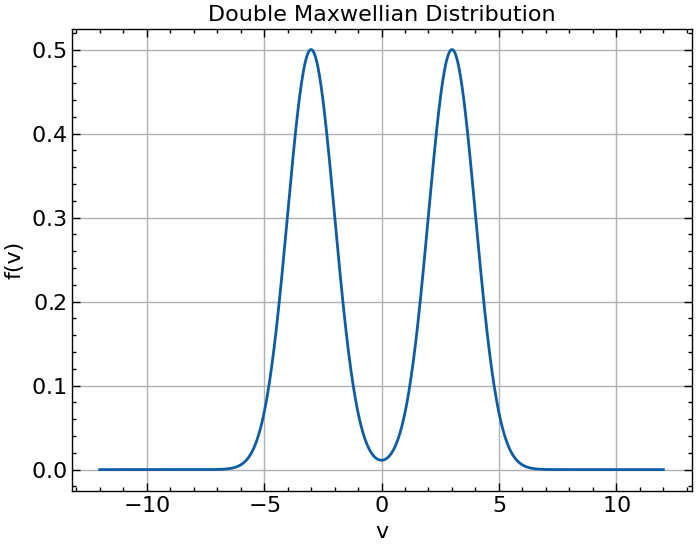

In [3]:
v_min, v_max = -4*vb, 4*vb # Let us remember that each distribution is almost a Gaussian distribution. 
v = np.linspace(v_min, v_max, 1000)
f = 0.5 * ( np.exp(-0.5 * (v - vb)**2) + np.exp(-0.5 * (v + vb)**2) )

plt.plot(v, f)
plt.title("Double Maxwellian Distribution")
plt.xlabel("v"); plt.ylabel("f(v)")
plt.grid(True); plt.show()

Let us remember that, for a Gaussian distribution $e^{-x^2/2}$, most of the probability is concentrated in
* ~68% within $\pm1$
* ~95% within $\pm2$
* ~99.7% within $\pm3$

So, to be safe at sampling, such that we are fully considering both beams, we have set the minimum and maximum values of the plot to be 4 times the mean speed. The maximum of the distribution happens when the velocity take the positive or negative value of the mean speed, 

$$
    f_{max} = f(x, \pm v_b) = f(\pm v_b) = \frac{n_0}{2\sqrt{2\pi}}\left(1 + e^{2v_b^2}\right) \rightarrow \frac{1}{2}\left(1 + e^{2v_b^2}\right)
$$

The $1/2\sqrt{2\pi}$ factor is droped for practical reasons. Why? It is possible to omit the prefactor for the purpose of the rejection sampling algorithm. Here is how the algorithm work:

1. Pick a random `v` in the interval `[v_min, v_max]`
2. Compute `f(v)` given the mean velocity `v_b`
3. Pick a random number $\gamma \in [0,f_{max}]$
4. Accept the chosen sample if $\gamma \leq f(v)$, otherwise, reject it
    * IMPORTANT: When implementing the code `f_max >= np.max(beam_shape)` because if `f_max` is simple chosen and it happens to become too small, then one would incorrectly reject valid samples. 

REMEMBER to add the prefactor $1/2\sqrt{2\pi}$ when doing physical analyses, like integration to estimate the charge density of electrons for specific values. When working only with the rejection sampling, one will be only sampling with respect to the _relative_ values of the distribution.  

In [4]:
# Initial positions
r = np.random.random(N)*L


# Initial velocities: utilizing REJECTION SAMPLING
def sample_velocity(v_b, tails_factor):
    f_max = 0.5 * (1.0 + np.exp(-2.0 * vb**2))
    vmin, vmax = -tails_factor*v_b, tails_factor*v_b
    
    velocities = np.zeros(N)
    i = 0
    while i < N:
        v_ = np.random.uniform(vmin, vmax) 
        beam_shape = 0.5 * (np.exp(-0.5 * (v_ - v_b)**2) + np.exp(-0.5 * (v_ + v_b)**2))
        gamma = np.random.rand()*f_max
        if gamma <= beam_shape:
            velocities[i] = v_
            i += 1
    return velocities
v = sample_velocity(vb, 4)


# HOW CAN WE MAKE THE REJECTION SAMPLING EVEN MORE EFFICIENT AND DEBUGGING FRIENDLY?
# # # Print for progess? 
# # # @njit from numba
# # # torch

### COMPUTING THE ELECTRON NUMBER DENSITY $n(x)$

We now compute the electron number density $n_j$ on the grid using linear weighting (aka Cloud-In-Cell method). Remember: 

$$
    n_j \:\rightarrow\: n_j + \left(\frac{x_{j+1} - r_j}{\delta x}\right)\frac{1}{\delta x}
$$


$$
    n_{j+1} \:\rightarrow\: n_{j+1} + \left(\frac{r_j-x_j}{\delta x}\right)\frac{1}{\delta x}
$$

In [5]:
def compute_density(r_):
    ne_ = np.zeros(J)
    j_ = (r_/dx).astype(int)
    y_ = (r_/dx) - j_
    
    for i in range(N):
        left,right = j_[i]%J, (j_[i]+1)%J # indexes w.r.t. j
        ne_[left ] += (1 - y_[i]) / dx
        ne_[right] += y_[i] / dx
    return ne_